In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%pylab inline

/Users/nurlan/.virtualenvs/cv/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('WAG_C_M.csv', sep=',', index_col=['month'], parse_dates=['month'], dayfirst=False)

In [3]:
data = data[::-1]

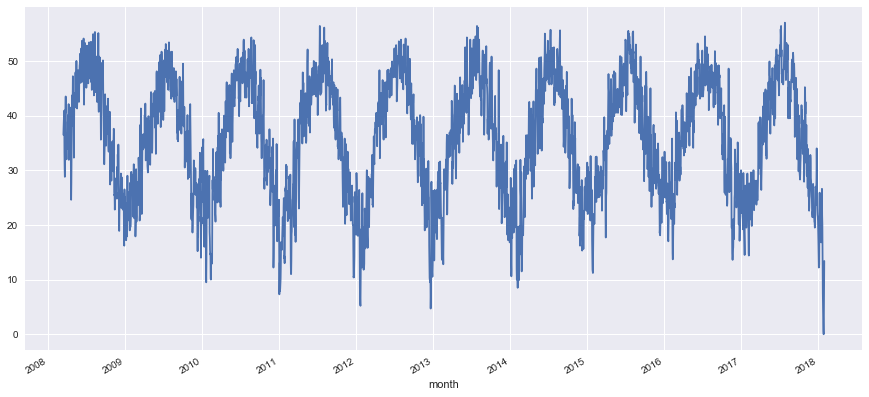

In [4]:
data['WAG_C_M'] = data['WAG_C_M'] + abs(data['WAG_C_M'].min()) + 0.001
plt.figure(figsize=(15,7))
data.WAG_C_M.plot()
plt.show()

Критерий Дики-Фуллера: p=0.030090


<Figure size 1080x504 with 0 Axes>

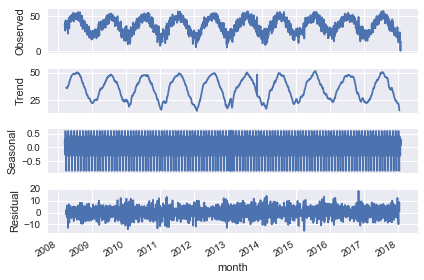

In [5]:
plt.figure(figsize=(15,7))
sm.tsa.seasonal_decompose(data.WAG_C_M, freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])
plt.show()

Свойства ряда:
    1) повышающийся тренд
    2) сезонность
    3) автокоррелированность
    4) большая дисперсия в конце ряда

# Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 1.231130
Критерий Дики-Фуллера: p=0.033201


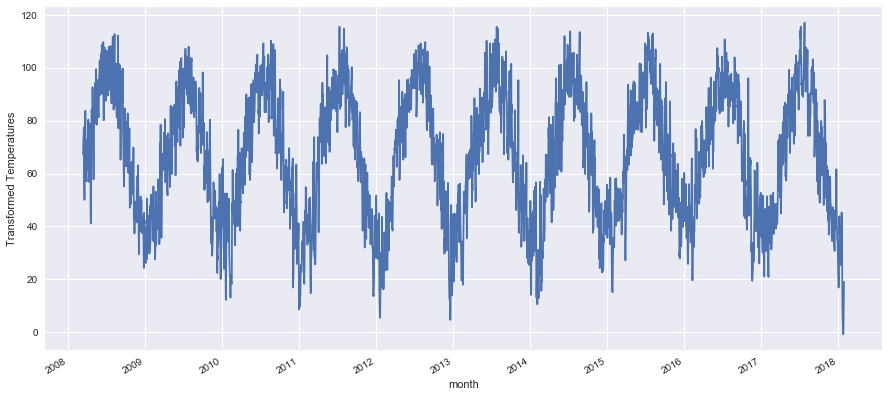

In [6]:
data['WAG_C_M_box'], lmbda = stats.boxcox(data['WAG_C_M'])
plt.figure(figsize=(15,7))
data['WAG_C_M_box'] = data['WAG_C_M_box']
data.WAG_C_M_box.plot()
plt.ylabel(u'Transformed Temperatures')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box)[1])

Ряд по-прежнему не является стационарным, дисперсия уменьшилась

# Стационарность

Критерий Дики-Фуллера: p=0.000000


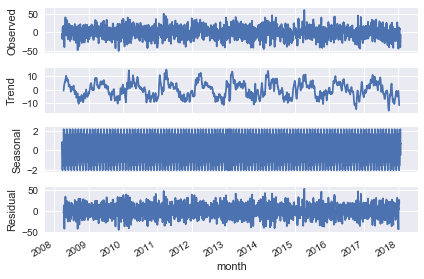

In [7]:
data['WAG_C_M_box_diff'] = data.WAG_C_M_box - data.WAG_C_M_box.shift(12)
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff[12:], freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но полностью избавиться от тренда не удалось.

Критерий Дики-Фуллера: p=0.000000


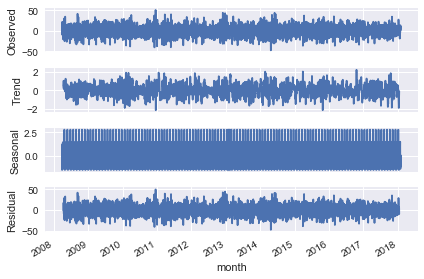

In [8]:
data['WAG_C_M_box_diff2'] = data.WAG_C_M_box_diff - data.WAG_C_M_box_diff.shift(1)
sm.tsa.seasonal_decompose(data.WAG_C_M_box_diff2[13:], freq=30).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M_box_diff2[13:])[1])

Критерий Дики-Фуллера полностью отвергает гипотезу нестационарности.

# Подбор модели

Посмотрим на ACF и PACF полученного ряда:

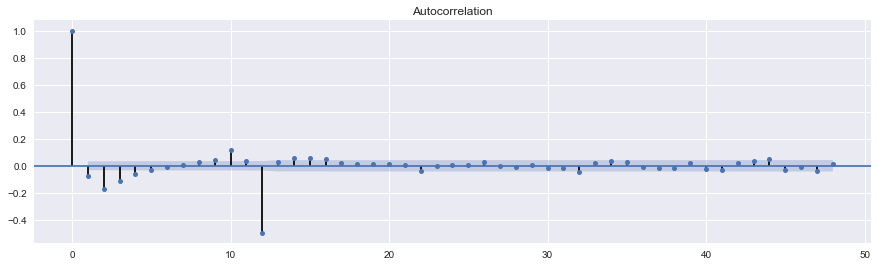

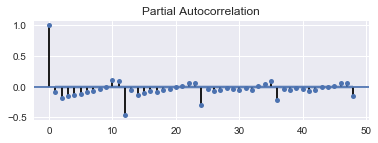

In [9]:
plt.figure(figsize=(15,9))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 1, P = 1, p = 1

In [10]:
ps = range(0, 2)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

In [11]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(data.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 1, 0)
CPU times: user 16.7 s, sys: 1.33 s, total: 18.1 s
Wall time: 24.9 s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
2  (0, 1, 1, 0)  27033.502991
4  (1, 0, 1, 0)  27050.970172
0  (0, 0, 1, 0)  27075.667583
1  (0, 1, 0, 0)  28057.402189
3  (1, 0, 0, 0)  28071.825824


In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                 3634
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood              -13513.751
Date:                            Sat, 17 Mar 2018   AIC                          27033.503
Time:                                    17:54:40   BIC                          27052.097
Sample:                                03-13-2008   HQIC                         27040.126
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1464      0.016     -9.105      0.000      -0.178      -0.115
ar.S.L12      -0.4970      0.013   

Остатки

Критерий Стьюдента: p=0.997507
Критерий Дики-Фуллера: p=0.000000


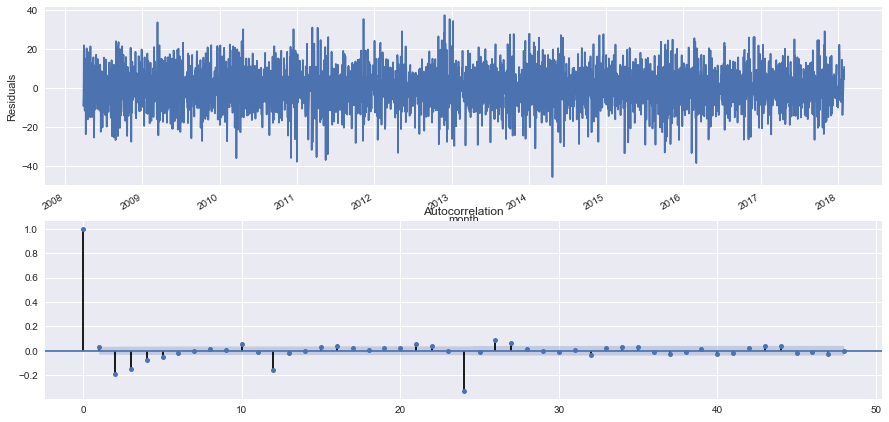

In [15]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

/Users/nurlan/.virtualenvs/cv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


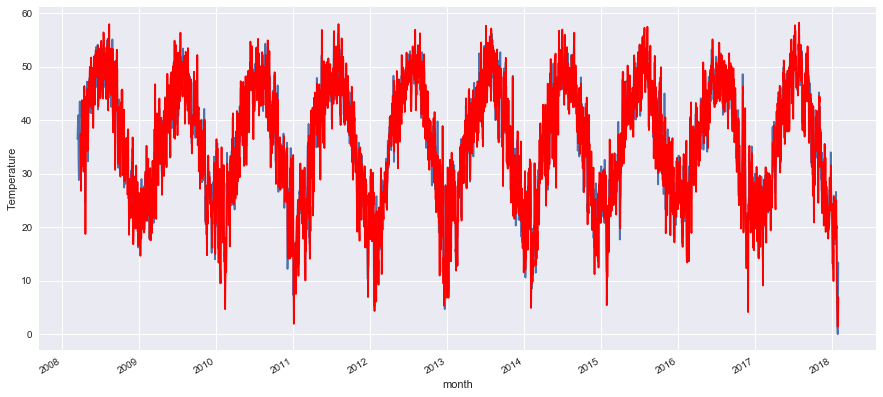

In [16]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.WAG_C_M.plot()
data.model[13:].plot(color='r')
plt.ylabel('Temperature')
pylab.show()

# Прогноз

            WAG_C_M  forecast
2008-03-13   36.501       NaN
2008-03-15   39.101       NaN
2008-03-16   39.701       NaN
2008-03-17   40.901       NaN
2008-03-18   33.301       NaN
2008-03-19   30.201       NaN
2008-03-20   28.801       NaN
2008-03-21   33.501       NaN
2008-03-22   41.001       NaN
2008-03-23   40.501       NaN
2008-03-24   43.501       NaN
2008-03-25   35.001       NaN
2008-03-26   34.801       NaN
2008-03-27   33.501       NaN
2008-03-28   32.001       NaN
2008-03-29   34.901       NaN
2008-03-30   36.701       NaN
2008-03-31   33.901       NaN
2008-04-01   34.901       NaN
2008-04-02   35.901       NaN
2008-04-03   38.901       NaN
2008-04-04   36.501       NaN
2008-04-05   40.101       NaN
2008-04-06   38.101       NaN
2008-04-07   42.101       NaN
2008-04-08   31.901       NaN
2008-04-09   32.801       NaN
2008-04-10   33.101       NaN
2008-04-11   35.301       NaN
2008-04-12   40.601       NaN
...             ...       ...
2019-05-15      NaN       NaN
2019-05-16

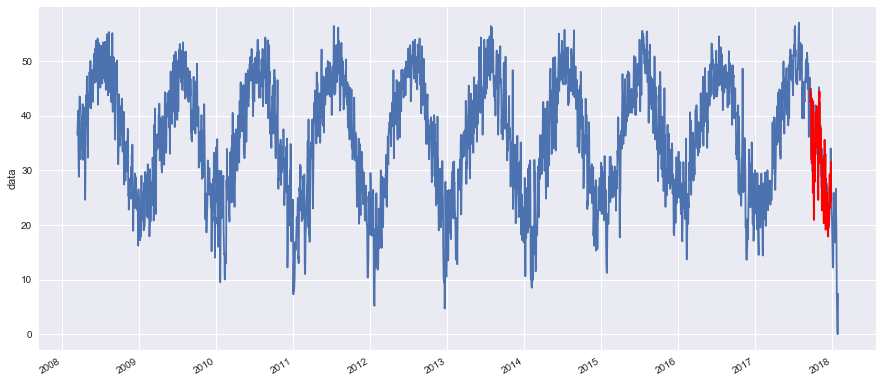

In [36]:
data2 = data[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2018-01-30", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,500)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=3500, end=3600), lmbda)
print(data2)
plt.figure(figsize(15,7))
data2.WAG_C_M.plot()
data2.forecast.plot(color='r')
plt.ylabel('data')
pylab.show()